In [1]:
from tensorboardX import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import time
from scipy.stats import genpareto
import torch.nn.functional as F
from torch.autograd import Variable
from torch import FloatTensor
import scipy.io as sio

In [2]:
def convTBNReLU(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(0.2, True),
    )


class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block1 = convTBNReLU(in_channels + 1, 512, 4, 1, 0)
        self.block2 = convTBNReLU(512, 256)
        self.block3 = convTBNReLU(256, 128)
        self.block4 = convTBNReLU(128, 64)
        self.block5 = nn.ConvTranspose2d(64, out_channels, 4, 2, 1)

    def forward(self, latent, continuous_code):
        inp = torch.cat((latent, continuous_code), 1)
        out = self.block1(inp)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return torch.tanh(self.block5(out))

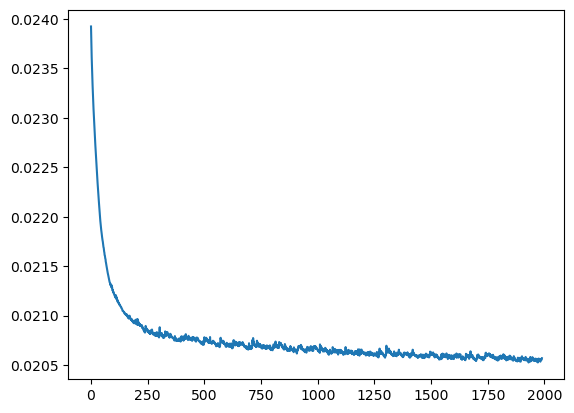

In [4]:
latentdim = 20
G = Generator(in_channels=latentdim, out_channels=1).cuda()
genpareto_params = (1.33, 0, 0.0075761900937239765)
threshold = -0.946046018600464
rv = genpareto(*genpareto_params)

G.load_state_dict(torch.load('../ExGAN/G999.pt'))
G.eval()

num = 57
G.requires_grad = False
real = torch.load('../data/test.pt').cuda()
real = real[0:57,:,:,:]
z = torch.zeros((num, latentdim, 1, 1)).cuda()
code = (real.sum((1, 2, 3))/4096).view((num, 1, 1, 1))
z.requires_grad = True
optimizer = torch.optim.Adam([z], lr=1e-2)
criterion = nn.MSELoss()
losses=[]
for i in range(2000):
    pred = G(z, code)
    loss = criterion(pred, real)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.cpu().data.item())
plt.plot(losses[10::])
sio.savemat('../data/EXGANRecLosses.mat', {'losses': losses})